Я парсил данные с сайта hhru, так как это один из самых популярных сайтов по поиску работу. Мой алгорит работает так: он сначала ищет вакансии, в которых указан уровень програмиста,
а потом добавляется еще грация по опыту(Junior - без опыта, Middle - от 1 года до 6 лет, Senior - от 6 лет). Я так сделал, чтобы поиск был однозначный.

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
import re

# Настройка параметров браузера
options = Options()
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("--start-maximized")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("--headless")
options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.83 Safari/537.36")

# Инициализация драйвера
browser = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# Словарь с идентификаторами регионов
region_codes = {"Москва": "1", "Санкт-Петербург": "2", "Нижний Новгород": "66", "Казань": "88"}

# Ключевые направления и уровни
specializations = ["Data+Analyst", "Data+Scientist", "Data+Engineer"]
skill_levels = ["Junior", "Middle", "Senior"]
locations = ["Москва", "Санкт-Петербург", "Нижний Новгород", "Казань"]

# Пустой массив для хранения данных
results = []

# Базовый URL для поиска вакансий
search_url_template = "https://hh.ru/search/vacancy"

# Функция для получения списка уровней опыта
def experience_filter(level):
    return {
        "Junior": ["noExperience"],
        "Middle": ["between1And3", "between3And6"],
        "Senior": ["moreThan6"]
    }.get(level, [])

# Функция для получения количества вакансий
def fetch_vacancy_count(specialization, level, city, experience=None):
    region_id = region_codes.get(city)
    if not experience:
        url = f"{search_url_template}?text={specialization}+{level}&search_field=name&area={region_id}"
    else:
        url = f"{search_url_template}?text={specialization}&search_field=name&area={region_id}&experience={experience}&excluded_text=junior%2C+middle%2C+senior"
    
    browser.get(url)

    try:
        # Парсим содержимое страницы
        soup = BeautifulSoup(browser.page_source, "html.parser")
        header = soup.find("h1", {"data-qa": "title"})
        total_vacancies = int(re.search(r"\d+", header.text).group())
        print(f"Вакансии {specialization} ({level}) в {city}: {total_vacancies}, опыт: {experience if experience else 'Все'}")
    except Exception as e:
        total_vacancies = 0
        print(f"Нет вакансий по {specialization} ({level}) в {city}, опыт: {experience if experience else 'Все'}")
    
    return total_vacancies

# Главный цикл по специализациям, уровням и городам
for spec in specializations:
    for lvl in skill_levels:
        for loc in locations:
            total = 0
            experiences = experience_filter(lvl)
            
            # Получение количества вакансий с явным указанием уровня
            total += fetch_vacancy_count(spec, lvl, loc, experience=None)

            # Добавление вакансий с фильтрацией по опыту работы
            for exp in experiences:
                total += fetch_vacancy_count(spec, lvl, loc, experience=exp)
            
            print(f"Итоговое количество для {spec} ({lvl}) в {loc}: {total}")
            results.append({'Направление': spec.replace('+', ' '), 'Уровень': lvl, 'Город': loc, 'Вакансии': total})

# Завершение работы браузера
browser.quit()

# Сохранение данных в файлы
df = pd.DataFrame(results)
df.to_csv('vacancies_report.csv', index=False)

print(df)


Вакансии Data+Analyst (Junior) в Москва: 10, опыт: Все
Вакансии Data+Analyst (Junior) в Москва: 7, опыт: noExperience
Итоговое количество для Data+Analyst (Junior) в Москва: 17
Вакансии Data+Analyst (Junior) в Санкт-Петербург: 4, опыт: Все
Вакансии Data+Analyst (Junior) в Санкт-Петербург: 1, опыт: noExperience
Итоговое количество для Data+Analyst (Junior) в Санкт-Петербург: 5
Нет вакансий по Data+Analyst (Junior) в Нижний Новгород, опыт: Все
Вакансии Data+Analyst (Junior) в Нижний Новгород: 1, опыт: noExperience
Итоговое количество для Data+Analyst (Junior) в Нижний Новгород: 1
Нет вакансий по Data+Analyst (Junior) в Казань, опыт: Все
Нет вакансий по Data+Analyst (Junior) в Казань, опыт: noExperience
Итоговое количество для Data+Analyst (Junior) в Казань: 0
Вакансии Data+Analyst (Middle) в Москва: 25, опыт: Все
Вакансии Data+Analyst (Middle) в Москва: 80, опыт: between1And3
Вакансии Data+Analyst (Middle) в Москва: 62, опыт: between3And6
Итоговое количество для Data+Analyst (Middle) в М

По графикам, можно сказать, что больше всего предложений в Москве, а ищут чаще всего программиста на позицию Middle(data-ingineer)

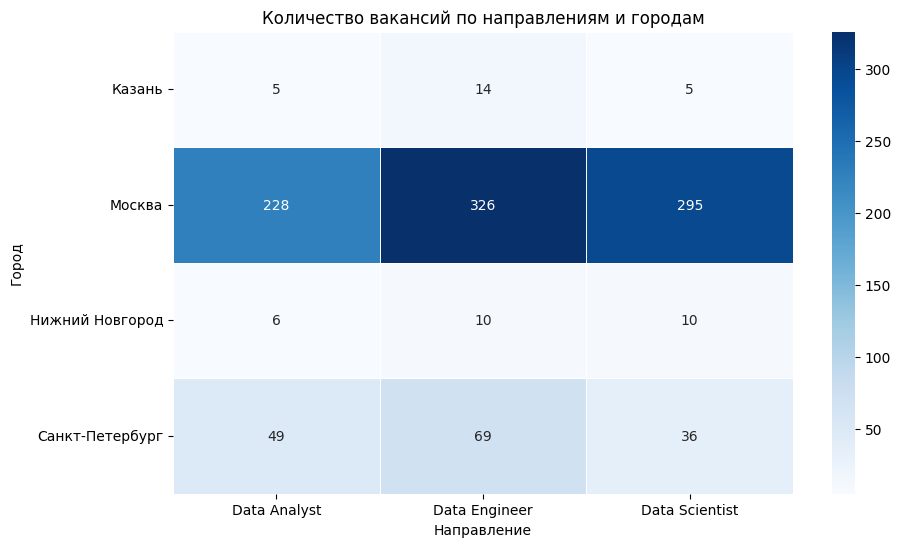

C:\Users\artem\AppData\Local\Temp\ipykernel_13840\797733265.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Уровень', y='Вакансии', hue='Направление', data=df, ci=None)


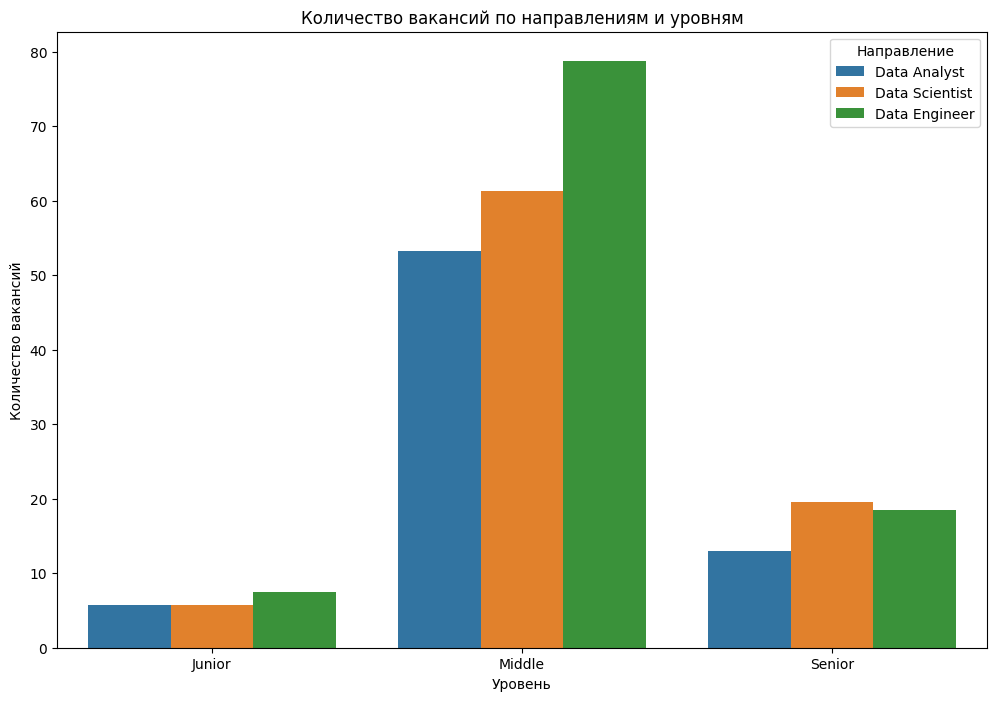

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Создание сводной таблицы для визуализации
pivot_table = df.pivot_table(index='Город', columns='Направление', values='Вакансии', aggfunc='sum')

# Построение тепловой карты вакансий по направлениям и городам
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="Blues", linewidths=.5)
plt.title('Количество вакансий по направлениям и городам')
plt.xlabel('Направление')
plt.ylabel('Город')
plt.show()

# Построение столбчатой диаграммы вакансий по направлениям, уровням и городам
plt.figure(figsize=(12, 8))
sns.barplot(x='Уровень', y='Вакансии', hue='Направление', data=df, ci=None)
plt.title('Количество вакансий по направлениям и уровням')
plt.xlabel('Уровень')
plt.ylabel('Количество вакансий')
plt.legend(title='Направление')
plt.show()
